In [1]:
import gc
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import json
# test

2024-06-22 08:56:44.859169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 08:56:44.859305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 08:56:45.037740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version:  2.15.0
GPU is available


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
def split_data(dataset, train_size, valid_size, test_size):
  total_length = len(dataset)
  train_length = int(np.floor(total_length * train_size))
  valid_length = int(np.floor(total_length * valid_size))

  train_data = dataset.take(train_length)
  remaining = dataset.skip(train_length)
  valid_data = remaining.take(valid_length)
  test_data = remaining.skip(valid_length)

#   train_x = x[:train_breakpoint]
#   train_y = y[:train_breakpoint]
#   valid_x = x[train_breakpoint:valid_breakpoint]
#   valid_y = y[train_breakpoint:valid_breakpoint]
#   test_x = x[valid_breakpoint:]
#   test_y = y[valid_breakpoint:]

  return train_data, valid_data, test_data

In [5]:
def convert_to_lab(image):
    image = np.array(image)
    # OpenCV's 'cvtColor' function expects the input image to be in the BGR color space,
    # so we need to convert from RGB to BGR first
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Now we can convert from BGR to CIE L*a*b*
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)

    return image_lab

In [6]:
def preprocess_data(img, label, use_lab_color_space=True):
  img = tf.image.resize(img, (128, 128))
  img /= 255.

  if (use_lab_color_space):
    img = tf.py_function(func=color.rgb2lab, inp=[img], Tout=tf.float32)
    img = (img + [0, 128, 128]) / [100, 255, 255]
    
#     img = color.rgb2lab(img, channel_axis=2)
#     img[:, :, 0] = img[:, :, 0] / 100
#     img[:, :, 1:] = (img[:, :, 1:] + 128) / 255

  img.set_shape((128, 128, 3))
  label = tf.one_hot(label, depth=38)

  return img, label

In [7]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

# PLANT VILLAGE

In [8]:
# Construct a tf.data.Dataset
dataset, ds_info = tfds.load('plant_village',
              split="train",
              with_info=True,
              shuffle_files=True,
              as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteD7R5OC/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [9]:
dataset.shuffle(500)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
print(len(dataset))

54303


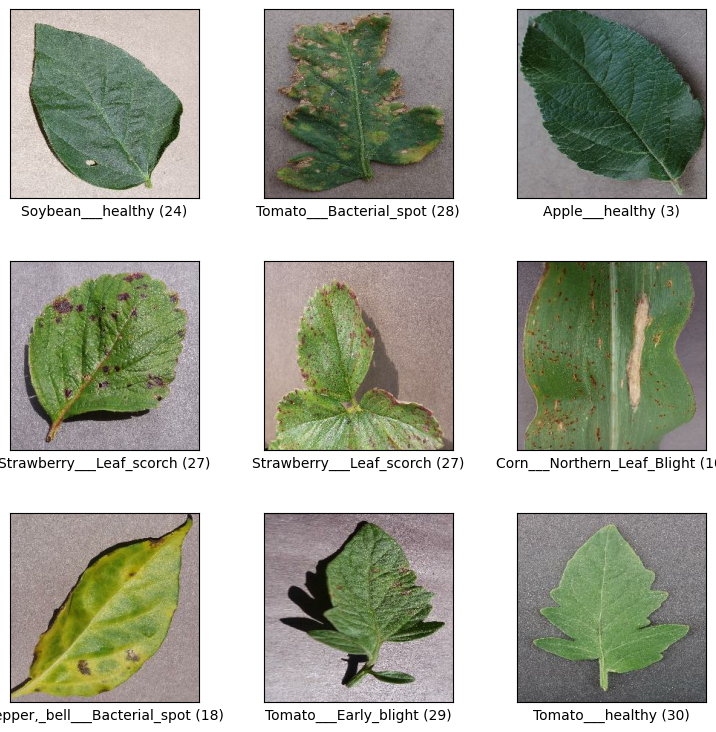

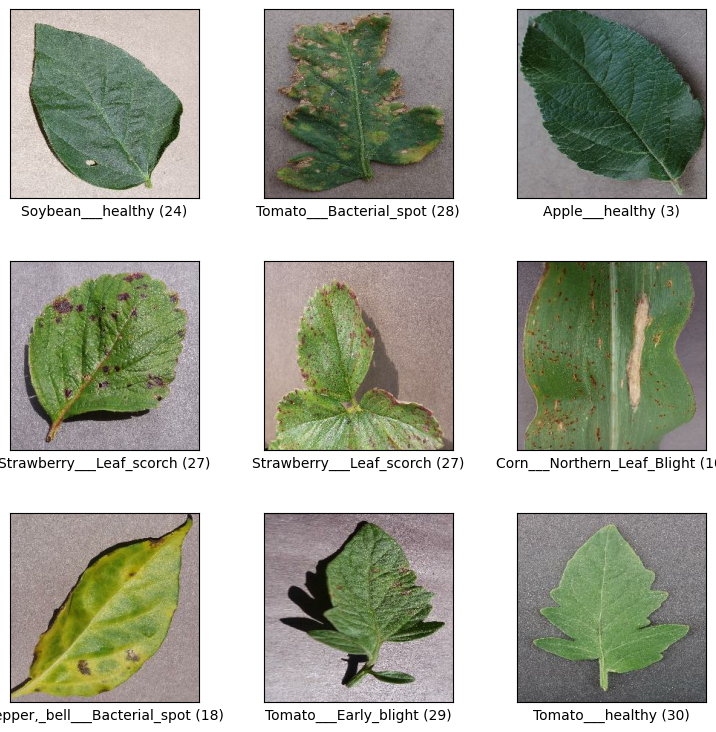

In [11]:
tfds.show_examples(dataset, ds_info)

In [12]:
dataset = dataset.map(preprocess_data)

[    0.          1157.98781723 -1409.58099604]
[0. 1. 1.]


/tmp/ipykernel_34/3154085906.py:17: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9836 negative Z values that have been clipped to zero
  ab_channel = color.lab2rgb(ab_channel)


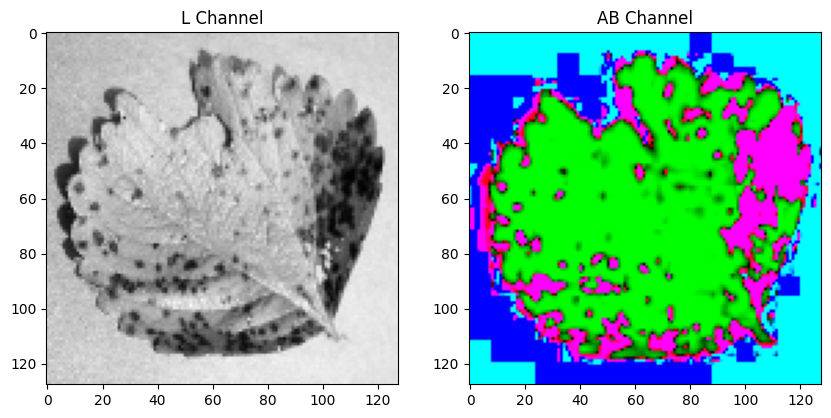

In [13]:
iterator = iter(dataset)
test= next(iterator)

# Search for data with early blight condition
if (np.argmax(test[1]) != 19):
    test = next(iterator)
    
test = np.copy(test[0])

l_channel = test[:, :, 0]

ab_channel = test[:, :, 1:]
ones_array = np.ones((ab_channel.shape[0], ab_channel.shape[1], 1))
ab_channel = np.concatenate((ones_array, ab_channel), axis=2)
ab_channel = (ab_channel * [100, 255, 255] - [0, 128, 128]) * [0, 255, 255]
print(ab_channel[0][0])
ab_channel = color.lab2rgb(ab_channel)

print(ab_channel[0][0])

# Plot the image
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)
axs[0].imshow(l_channel, cmap='gray')
axs[0].set_title('L Channel')
axs[1].imshow(ab_channel)
axs[1].set_title('AB Channel')

# Show the plot
plt.show()

In [14]:
train_data, valid_data, test_data = split_data(
    dataset=dataset,
    train_size=0.6,
    valid_size=0.2,
    test_size=0.2
  )

In [15]:
print(len(train_data), len(valid_data), len(test_data))

32581 10860 10862


In [16]:
train_data = train_data.cache().shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# TWO BRANCH INCEPTION V3

In [17]:
module_filters = [
    [64, 48, 64, 64, 96, 96, 32],
    [64, 48, 64, 64, 96, 96, 64],
    [64, 48, 64, 64, 96, 96, 64],
    [384, 64, 96, 96],
    [192, 128, 128, 192, 128, 128, 128, 128, 192, 192],
    [192, 160, 160, 192, 160, 160, 160, 160, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [192, 320, 192, 192, 192, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
]

In [40]:
@tf.keras.utils.register_keras_serializable()
class CopyChannels(tf.keras.layers.Layer):
    """
    This layer copies channels from channel_start the number of channels given in channel_count.
    """
    def __init__(self,
                 channel_start=0,
                 channel_count=1,
                 **kwargs):
        self.channel_start=channel_start
        self.channel_count=channel_count
        super(CopyChannels, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (32, input_shape[0], input_shape[1], self.channel_count)

    def call(self, x):
        return x[:, :, :, self.channel_start:(self.channel_start+self.channel_count)]

    def get_config(self):
        config = {
            'channel_start': self.channel_start,
            'channel_count': self.channel_count
        }
        base_config = super(CopyChannels, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(scale=False)(x)
    return tf.keras.layers.Activation('relu')(x)

In [20]:
def inception_module_1(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], 3)

  t3 = conv2d_bn(x, filters[3], 1)
  t3 = conv2d_bn(t3, filters[4], 3)
  t3 = conv2d_bn(t3, filters[5], 3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[6], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [21]:
def inception_module_2(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], (1,7))
  t2 = conv2d_bn(t2, filters[3], (7,1))

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], (1,7))
  t3 = conv2d_bn(t3, filters[6], (7,1))
  t3 = conv2d_bn(t3, filters[7], (1,7))
  t3 = conv2d_bn(t3, filters[8], (7,1))

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[9], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [22]:
def inception_module_3(x, filters):
  t1 = conv2d_bn(x, 384, 3)

  t2 = conv2d_bn(x, filters[1], 1)
  t2_1 = conv2d_bn(t2, filters[2], (1,3))
  t2_2 = conv2d_bn(t2, filters[3], (3,1))
  t2 = tf.keras.layers.concatenate([t2_1, t2_2], axis=3)

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], 1)
  t3_1 = conv2d_bn(t3, filters[6], (1,3))
  t3_2 = conv2d_bn(t3, filters[7], (3,1))
  t3 = tf.keras.layers.concatenate([t3_1, t3_2], axis=3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[8], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [23]:
def grid_size_reduction_1(x, filters):
    t1 = conv2d_bn(x, filters[0], 3, strides=(2,2), padding="valid")

    t2 = conv2d_bn(x, filters[1], 1)
    t2 = conv2d_bn(t2, filters[2], 3)
    t2 = conv2d_bn(t2, filters[3], 3, strides=(2,2), padding="valid")

    t3 = tf.keras.layers.MaxPooling2D(3, strides=(2,2))(x)

    return tf.keras.layers.concatenate([t1, t2, t3], axis=3)

In [24]:
def grid_size_reduction_2(x, filters):
    t1 = conv2d_bn(x, filters[0], 1)
    t1 = conv2d_bn(t1, filters[1], 3, strides=(2,2), padding="valid")

    t2 = conv2d_bn(x, filters[2], 1)
    t2 = conv2d_bn(t2, filters[3], (1,7))
    t2 = conv2d_bn(t2, filters[4], (7,1))
    t2 = conv2d_bn(t2, filters[5], 3, strides=(2,2), padding="valid")

    t3 = tf.keras.layers.MaxPooling2D(3, strides=(2,2))(x)

    return tf.keras.layers.concatenate([t1, t2, t3], axis=3)

In [25]:
def two_path_inception_v3(
                include_top=True,
                include_first_block=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(128,128,3),
                pooling=None,
                classes=38,
                two_paths_partial_first_block=0,
                two_paths_first_block=True,
                l_ratio=0.2,
                ab_ratio=0.8,
                max_mix_idx=12,
                model_name='two_path_inception_v3',
                **kwargs):

    img_input = tf.keras.layers.Input(shape=input_shape)

    if include_first_block:
        if two_paths_first_block:
            if (l_ratio>0):
                l_branch = CopyChannels(0,1)(img_input)
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), strides=(2, 2), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), (3, 3))
                l_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            if (ab_ratio>0):
                ab_branch = CopyChannels(1,2)(img_input)
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), strides=(2, 2), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), (3, 3))
                ab_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            if (l_ratio>0):
                if (ab_ratio>0):
                    x = tf.keras.layers.Concatenate(axis=3, name='concat_first_block')([l_branch, ab_branch])
                else:
                    x = l_branch
            else:
                x = ab_branch
        else:
            single_branch = conv2d_bn(img_input, 32, (3, 3), strides=(2, 2), padding='valid')
            single_branch = conv2d_bn(single_branch, 32, (3, 3), padding='valid')
            single_branch = conv2d_bn(single_branch, 64, (3, 3))
            single_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)
            # print('single path first block')
            x = single_branch

    if max_mix_idx >= 0:
        for i in range(max_mix_idx):
          if i < 3:
            x = inception_module_1(x, module_filters[i])
          elif i == 3:
            x = grid_size_reduction_1(x, module_filters[i])
          elif i < 8:
            x = inception_module_2(x, module_filters[i])
          elif i == 8:
            x = grid_size_reduction_2(x, module_filters[i])
          else:
            x = inception_module_3(x, module_filters[i])

    if include_top:
        # Classification block
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = tf.keras.models.Model(inputs, x, name=model_name)
    return model

# EXPERIMENTS

In [42]:
checkpoint_path = "/kaggle/working/two_branch_inception_v3_test/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [43]:
print("Train data shape:", tf.data.experimental.cardinality(train_data).numpy())
print("Valid data shape:", tf.data.experimental.cardinality(valid_data).numpy())

Train data shape: 1019
Valid data shape: 340


In [44]:
# Inspect the shape of one element of train_data
for image, label in train_data.take(5):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)

Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)


In [45]:
model = two_path_inception_v3(max_mix_idx=6)

In [30]:
model.summary()

Model: "two_path_inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ copy_channels       │ (32, None, 128,   │          0 │ input_layer[0][0] │
│ (CopyChannels)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ copy_channels_1     │ (32, None, 128,   │          0 │ input_layer[0][0] │
│ (CopyChannels)      │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (32, None, 63, 6) │         54 │ copy_channels[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (32, None, 63,    │        468 │ copy_channels_1[… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (32, None, 63, 6) │         18 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, None, 63,    │         78 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (32, None, 63, 6) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (32, None, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (32, None, 61, 6) │        324 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (32, None, 61,    │      6,084 │ activation_3[0][… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, None, 61, 6) │         18 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (32, None, 61,    │         78 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (32, None, 61, 6) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (32, None, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (32, None, 61,    │        702 │ activation_1[0][… │
│                     │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (32, None, 61,    │     11,934 │ activation_4[0][… │
│                     │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,840,676 (18.47 MB)

 Trainable params: 4,829,700 (18.42 MB)

 Non-trainable params: 10,976 (42.88 KB)

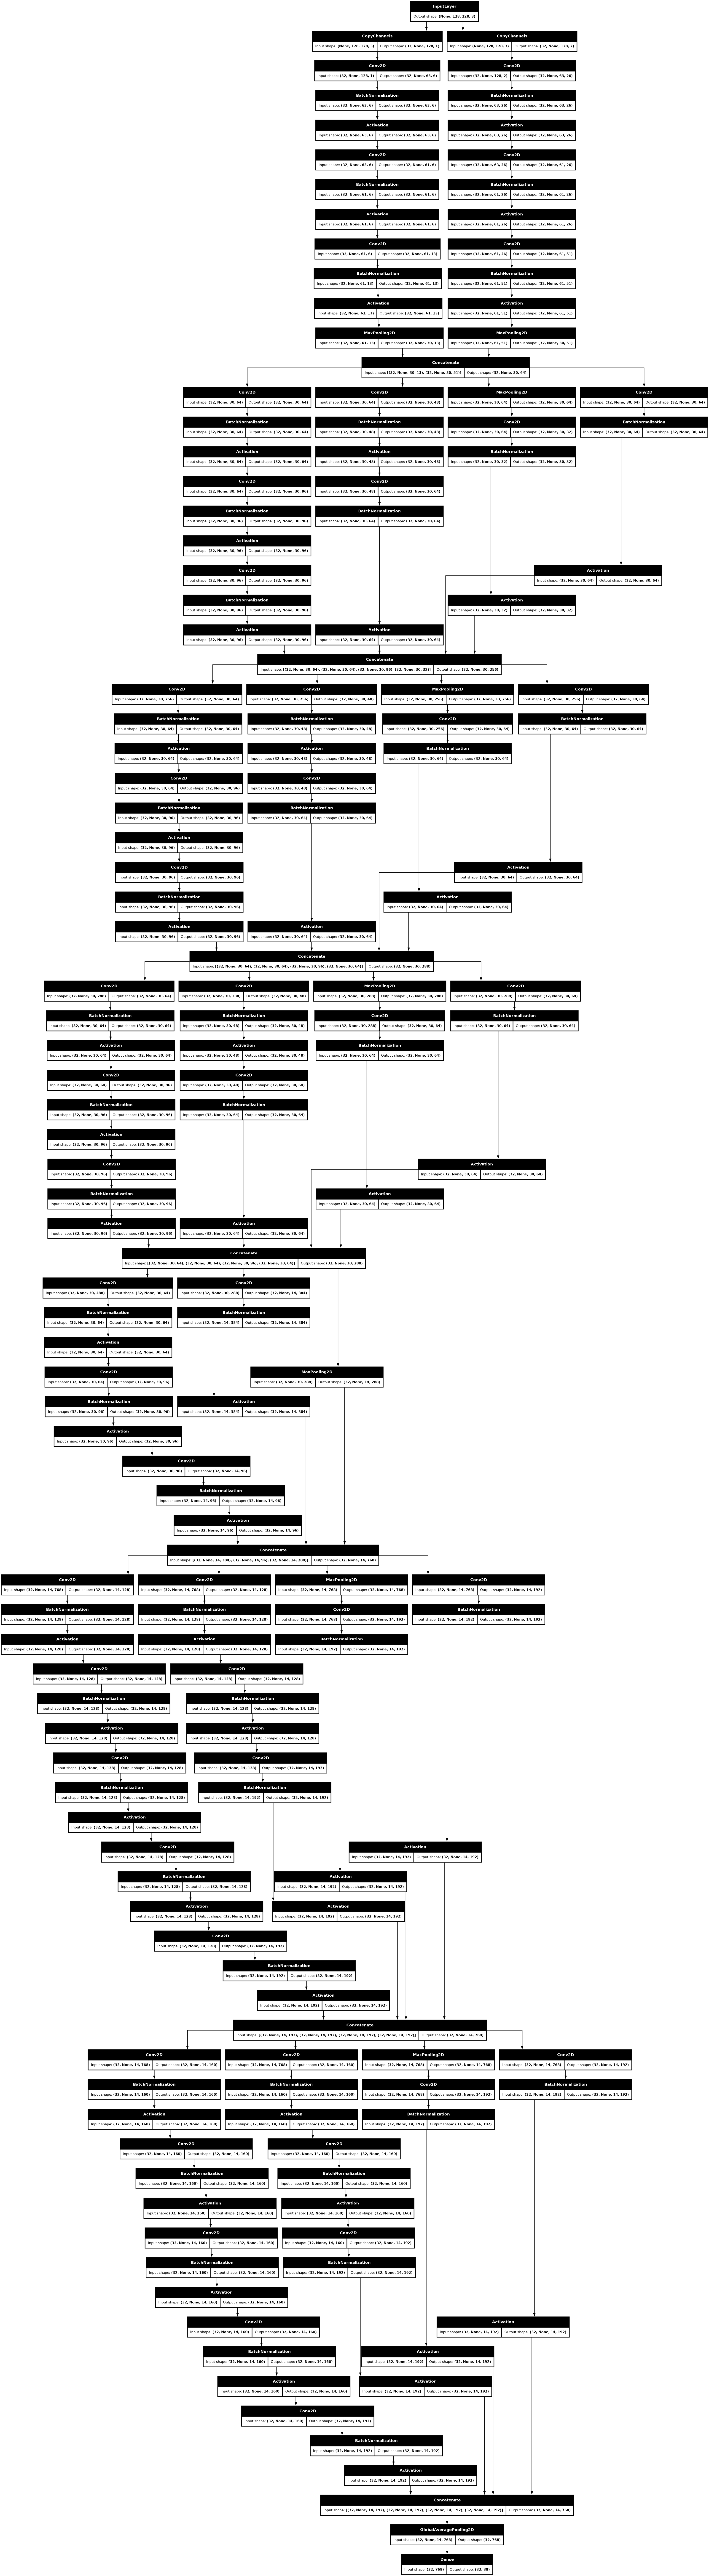

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [46]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        metrics=['accuracy'])

In [47]:
monitor='val_accuracy'
epochs=25

history = model.fit(
    train_data,
    verbose=1,
    epochs=1,
    validation_data=valid_data,
    callbacks=[checkpoint_callback]
)

   1/1019 ━━━━━━━━━━━━━━━━━━━━ 17:41:28 63s/step - accuracy: 0.0938 - loss: 3.7786

W0000 00:00:1719051122.760073     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6929 - loss: 1.1019

W0000 00:00:1719051269.296385     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719051272.373069     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.22219, saving model to /kaggle/working/two_branch_inception_v3_test/cp-0001.keras


W0000 00:00:1719051286.007886     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 226s 161ms/step - accuracy: 0.6931 - loss: 1.1014 - val_accuracy: 0.2222 - val_loss: 4.9880


In [48]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_inception_v3_test/cp-0001.keras')

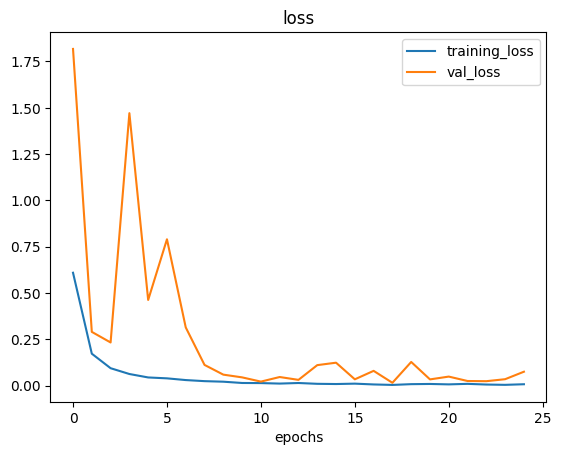

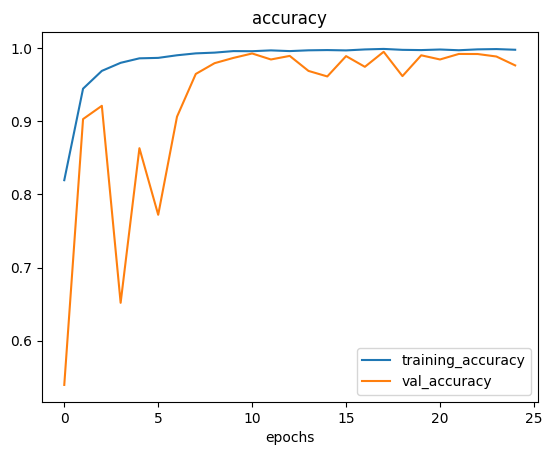

In [34]:
plot_loss_curves(history)

In [41]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_inception_v3/cp-0018.keras')

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'two_path_inception_v3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': None, 'class_name': 'CopyChannels', 'config': {'name': 'copy_channels', 'trainable': True, 'dtype': 'float32', 'channel_start': 0, 'channel_count': 1}, 'registered_name': 'CopyChannels', 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'copy_channels', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CopyChannels', 'config': {'name': 'copy_channels_1', 'trainable': True, 'dtype': 'float32', 'channel_start': 1, 'channel_count': 2}, 'registered_name': 'CopyChannels', 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'copy_channels_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 128, 1]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 128, 1], 'dtype': 'float32', 'keras_history': ['copy_channels', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 26, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 128, 2]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 128, 2], 'dtype': 'float32', 'keras_history': ['copy_channels_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 6]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 6], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 26]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 26], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 6]}, 'name': 'activation', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 6], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_3', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 26]}, 'name': 'activation_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 6, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 6]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 6], 'dtype': 'float32', 'keras_history': ['activation', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 26, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 63, 26]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 63, 26], 'dtype': 'float32', 'keras_history': ['activation_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 6]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 6], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 26]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 26], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 6]}, 'name': 'activation_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 6], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_4', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 26]}, 'name': 'activation_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 26], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 13, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 6]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 6], 'dtype': 'float32', 'keras_history': ['activation_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 51, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 26]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 26], 'dtype': 'float32', 'keras_history': ['activation_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 13]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 13], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 51]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 51], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_2', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 13]}, 'name': 'activation_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 13], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_5', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 51]}, 'name': 'activation_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 51], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 13]}, 'name': 'max_pooling2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 13], 'dtype': 'float32', 'keras_history': ['activation_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 61, 51]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 61, 51], 'dtype': 'float32', 'keras_history': ['activation_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concat_first_block', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 30, 13], [32, None, 30, 51]]}, 'name': 'concat_first_block', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 13], 'dtype': 'float32', 'keras_history': ['max_pooling2d', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 51], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['concat_first_block', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['concat_first_block', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_7', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'activation_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['concat_first_block', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['concat_first_block', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['activation_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['max_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 32]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 32], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_6', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_11', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_12', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 32]}, 'name': 'activation_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 30, 64], [32, None, 30, 64], [32, None, 30, 96], [32, None, 30, 32]]}, 'name': 'concatenate', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_6', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_11', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 32], 'dtype': 'float32', 'keras_history': ['activation_12', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 256]}, 'name': 'conv2d_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 256], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_16', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_16', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 256]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 256], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_17', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_17', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_14', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'activation_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_17', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 256]}, 'name': 'max_pooling2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 256], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 256], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['activation_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'conv2d_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 256]}, 'name': 'conv2d_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 256], 'dtype': 'float32', 'keras_history': ['max_pooling2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_15', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_18', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_18', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_19', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_19', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_13', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_15', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_18', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_19', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 30, 64], [32, None, 30, 64], [32, None, 30, 96], [32, None, 30, 64]]}, 'name': 'concatenate_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_13', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_15', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_18', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_19', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_23', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_23', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_23', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': True, 'dtype': 'float32', 'filters': 48, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_21', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'batch_normalization_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['conv2d_21', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_24', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_24', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_21', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'activation_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['batch_normalization_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_24', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_4', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'max_pooling2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 48]}, 'name': 'conv2d_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 48], 'dtype': 'float32', 'keras_history': ['activation_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'conv2d_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['max_pooling2d_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_20', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_20', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_22', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_22', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_25', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_25', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_26', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_26', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_20', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_22', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_25', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_26', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_2', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 30, 64], [32, None, 30, 64], [32, None, 30, 96], [32, None, 30, 64]]}, 'name': 'concatenate_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_20', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_22', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_25', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_26', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_28', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'batch_normalization_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['conv2d_28', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_28', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'activation_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 64]}, 'name': 'conv2d_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 64], 'dtype': 'float32', 'keras_history': ['activation_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_29', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'batch_normalization_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['conv2d_29', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_29', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'activation_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': True, 'dtype': 'float32', 'filters': 384, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'conv2d_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 96]}, 'name': 'conv2d_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 96], 'dtype': 'float32', 'keras_history': ['activation_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_27', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 384]}, 'name': 'batch_normalization_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 384], 'dtype': 'float32', 'keras_history': ['conv2d_27', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_30', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 96]}, 'name': 'batch_normalization_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 96], 'dtype': 'float32', 'keras_history': ['conv2d_30', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_27', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 384]}, 'name': 'activation_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 384], 'dtype': 'float32', 'keras_history': ['batch_normalization_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_30', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 96]}, 'name': 'activation_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 96], 'dtype': 'float32', 'keras_history': ['batch_normalization_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_5', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 30, 288]}, 'name': 'max_pooling2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 30, 288], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_3', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 14, 384], [32, None, 14, 96], [32, None, 14, 288]]}, 'name': 'concatenate_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 384], 'dtype': 'float32', 'keras_history': ['activation_27', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 96], 'dtype': 'float32', 'keras_history': ['activation_30', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 288], 'dtype': 'float32', 'keras_history': ['max_pooling2d_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_35', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_35', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_35', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_35', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_35', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_36', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_35', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_36', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_36', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_36', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_36', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_37', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_36', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_32', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_32', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_37', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_37', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_32', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_37', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_37', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_38', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_37', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_33', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_33', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_38', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'batch_normalization_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['conv2d_38', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_33', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_33', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_38', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'activation_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_6', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'max_pooling2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_34', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_33', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_39', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 128]}, 'name': 'conv2d_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 128], 'dtype': 'float32', 'keras_history': ['activation_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_40', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['max_pooling2d_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_31', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_31', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_34', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_34', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_39', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_39', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_40', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_40', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_31', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_34', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_34', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_39', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_39', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_40', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_4', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 14, 192], [32, None, 14, 192], [32, None, 14, 192], [32, None, 14, 192]]}, 'name': 'concatenate_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_31', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_34', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_39', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_40', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_45', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_45', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_45', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_46', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_46', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_46', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_42', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_47', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_42', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_42', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_47', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_42', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_47', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_43', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_48', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_43', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_43', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_48', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'batch_normalization_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['conv2d_48', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_43', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_48', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'activation_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['batch_normalization_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_7', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'same', 'strides': [1, 1], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'max_pooling2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_41', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_44', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_49', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [7, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 160]}, 'name': 'conv2d_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 160], 'dtype': 'float32', 'keras_history': ['activation_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_50', 'trainable': True, 'dtype': 'float32', 'filters': 192, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'conv2d_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['max_pooling2d_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_41', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_41', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_44', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_49', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_49', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_50', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'batch_normalization_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['conv2d_50', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_41', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_44', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_49', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_49', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_50', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 192]}, 'name': 'activation_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_5', 'trainable': True, 'dtype': 'float32', 'axis': 3}, 'registered_name': None, 'build_config': {'input_shape': [[32, None, 14, 192], [32, None, 14, 192], [32, None, 14, 192], [32, None, 14, 192]]}, 'name': 'concatenate_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_41', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_44', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_49', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 192], 'dtype': 'float32', 'keras_history': ['activation_50', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'avg_pool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [32, None, 14, 768]}, 'name': 'avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, None, 14, 768], 'dtype': 'float32', 'keras_history': ['concatenate_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'predictions', 'trainable': True, 'dtype': 'float32', 'units': 38, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [32, 768]}, 'name': 'predictions', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [32, 768], 'dtype': 'float32', 'keras_history': ['avg_pool', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['predictions', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'SGD', 'config': {'name': 'SGD', 'learning_rate': 0.009999999776482582, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.9, 'nesterov': True}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Could not locate class 'CopyChannels'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'CopyChannels', 'config': {'name': 'copy_channels', 'trainable': True, 'dtype': 'float32', 'channel_start': 0, 'channel_count': 1}, 'registered_name': 'CopyChannels', 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'copy_channels', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}

In [36]:
model.evaluate(test_data, verbose=1)

KeyboardInterrupt: 